# Capstone Project: Battle of the Neighborhoods

## Introduction

This project will search for the best neighborhood in **New York City (NYC)** to invest in an **Italian restaurant** and determine which neighborhood is best to open a new Italian restaurant. To determine where to invest in a restaurant we will look at restaurants with an average rating above 8.25; new resaurants will be opened in neighborhoods containing at least 3 restaurants and average ratings of 8.25 or below.  

This analysis will search for the neighborhoods using **Foursquare** data. Map data obtained from **Google**.

## Analysis

### Import Libraries

In [28]:
import numpy as np 
import pandas as pd 
import requests 
import os
import folium 
from geopy.geocoders import Nominatim 
import requests 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline
!conda install -c conda-forge folium=0.5.0 --yes
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Foursquare 

In [348]:
# Foursquare data removed for sharing

In [347]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Data

We want to locate the area of NYC with the highest concetration of Italian restaurants. Within that area, we want to separate the high rated restaurants from the low rated restaurants. That data will be used to create separate plots of the average rating of Italian restaurants per neighborhood.

In [54]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [32]:
ny_data.shape

(306, 4)

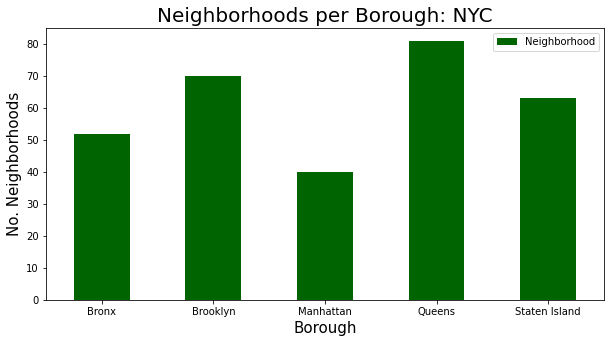

In [449]:
clr = "darkgreen"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [42]:
# create a list containing all Italian restaurants in NYC 
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
   # print('(',count,'/',len(ny_data),')','italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
   # print(row)
    for resturant_detail in italian_restaurants.values.tolist():
        id, name , category=resturant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

In [52]:
italian_rest_ny

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood
4,Bronx,Bedford Park,4b1712a8f964a520dbc123e3,Jolly Tinker
5,Bronx,Parkchester,5197f6507dd2310725c35f1e,Lorraine's Bar and Grill
6,Bronx,Morris Park,4b10591af964a5205f6e23e3,Patricia's
7,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
9,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...


In [51]:
italian_rest_ny.to_csv('italian_rest_ny_tocsv1.csv')
italian_ny = pd.read_csv('italian_rest_ny_tocsv1.csv')
italian_rest_ny.tail()

,Borough,Neighborhood,ID,Name
231,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa
232,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's
233,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's
234,Staten Island,Prince's Bay,4c091311a1b32d7f5efb96f0,Certo's Gourmet Foods & Caterers
235,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde


In [45]:
italian_rest_ny.shape

(236, 4)

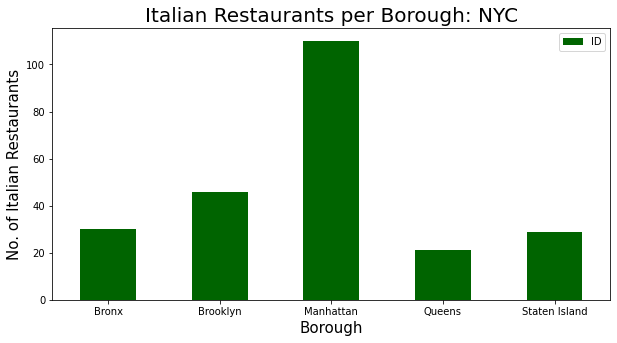

In [454]:
# Italian restaurants per borough
italian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

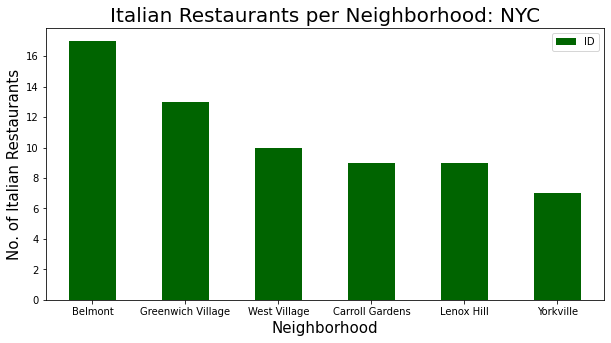

In [450]:
NOofNeigh = 6 # top number for graphing all the same past 6
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Italian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Italian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [48]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
110,Manhattan,Murray Hill,4b3c0273f964a520488025e3,Rossinis


In [101]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
italian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '60ba66772f369a3b3e0f4324'}, 'response': {'venue': {'id': '511edb6de4b0d58346fd272d', 'name': "Patrizia's Of Woodlawn", 'contact': {'phone': '7188845700', 'formattedPhone': '(718) 884-5700'}, 'location': {'address': '4358 Katonah Ave', 'lat': 40.900638399332884, 'lng': -73.86772361835486, 'labeledLatLngs': [{'label': 'display', 'lat': 40.900638399332884, 'lng': -73.86772361835486}, {'label': 'entrance', 'lat': 40.900601, 'lng': -73.867611}], 'postalCode': '10470', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4358 Katonah Ave', 'Bronx, NY 10470', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/patrizias-of-woodlawn/511edb6de4b0d58346fd272d', 'categories': [{'id': '4bf58dd8d48988d110941735', 'name': 'Italian Restaurant', 'pluralName': 'Italian Restaurants', 'shortName': 'Italian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/italian_', 'suffix': '.png'}, 'primary': True}],

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
231,Manhattan,Flatiron,4b741ab4f964a5202cc82de3,Novità Cucina Creativa,112,8.5,41
232,Brooklyn,Fulton Ferry,593c0d2262420b7feccc3048,Cecconi's,342,8.8,73
233,Brooklyn,Dumbo,593c0d2262420b7feccc3048,Cecconi's,342,8.8,73
234,Staten Island,Prince's Bay,0,0,0,0.0,0
235,Staten Island,Lighthouse Hill,5079ccdce4b065f1dd8155ad,Casa verde,8,7.8,3


In [103]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny_csv.csv')

In [102]:
italian_rest_stats_ny.shape

(236, 7)

In [104]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       236 non-null    object 
 1   Neighborhood  236 non-null    object 
 2   ID            236 non-null    object 
 3   Name          236 non-null    object 
 4   Likes         236 non-null    object 
 5   Rating        236 non-null    float64
 6   Tips          236 non-null    object 
dtypes: float64(1), object(6)
memory usage: 13.0+ KB


In [105]:
italian_rest_stats_ny['Likes'] = italian_rest_stats_ny['Likes'].astype('float64')
italian_rest_stats_ny['Tips'] = italian_rest_stats_ny['Tips'].astype('float64')
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       236 non-null    object 
 1   Neighborhood  236 non-null    object 
 2   ID            236 non-null    object 
 3   Name          236 non-null    object 
 4   Likes         236 non-null    float64
 5   Rating        236 non-null    float64
 6   Tips          236 non-null    float64
dtypes: float64(3), object(4)
memory usage: 13.0+ KB


In [323]:
italian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,236.000000,236.000000,236.000000
mean,130.262712,7.473305,51.000000
std,231.038117,2.145953,103.297999
min,0.000000,0.000000,0.000000
25%,12.000000,7.500000,7.000000
50%,37.000000,8.000000,18.000000
75%,120.000000,8.500000,46.500000
max,1449.000000,9.400000,1136.000000


In [324]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                    Gramercy
ID              4afb2990f964a520a91b22e3
Name                            Maialino
Likes                             1449.0
Rating                               8.4
Tips                               467.0
Name: 151, dtype: object

In [108]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              5a00f3538496ca58fd9e2856
Name                  Evelina Restaurant
Likes                              210.0
Rating                               9.4
Tips                                38.0
Name: 54, dtype: object

In [109]:
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                               22.0
Rating                               8.2
Tips                              1136.0
Name: 179, dtype: object

In [336]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,Bushwick,9.200000
86,Tribeca,9.200000
45,Hamilton Heights,9.100000
9,Bedford Stuyvesant,9.100000
12,Boerum Hill,9.100000
38,Fulton Ferry,8.800000
28,Dumbo,8.800000
25,Corona,8.800000
92,West Village,8.750000
44,Greenwich Village,8.715385


In [337]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.268182
0,Bronx,7.636667
3,Queens,7.195238
1,Brooklyn,6.841304
4,Staten Island,5.493103


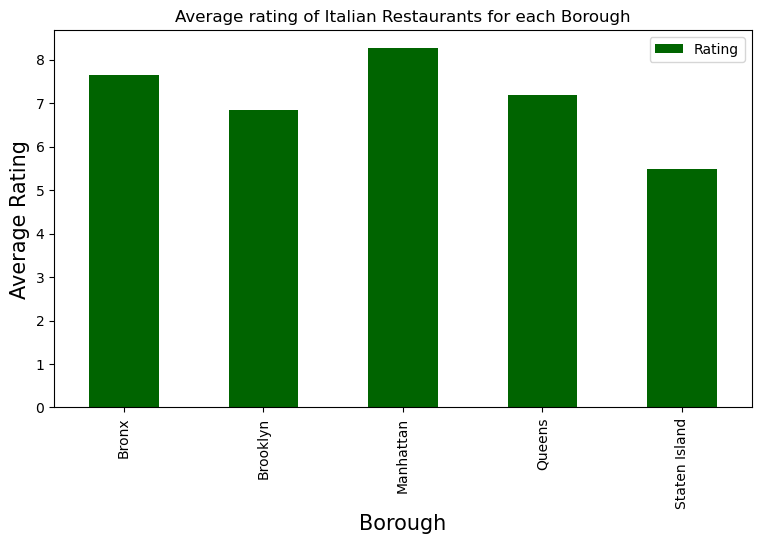

In [451]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Italian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
italian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

### Neighborhoods to Invest in a Restaurant

Choose a neighborhood that has Italian restaurants that are performing well. Select restaurants with a rating above 8.25. 

In [339]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>8.25]
ny_neighborhood_stats

,Neighborhood,Average Rating
9,Bedford Stuyvesant,9.100000
12,Boerum Hill,9.100000
13,Bushwick,9.200000
18,City Island,8.300000
21,Clinton Hill,8.333333
22,Cobble Hill,8.533333
24,Concourse Village,8.300000
25,Corona,8.800000
28,Dumbo,8.800000
30,East Village,8.366667


In [341]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,9.100000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
2,Brooklyn,Bushwick,40.698116,-73.925258,9.200000
3,Bronx,City Island,40.847247,-73.786488,8.300000
4,Brooklyn,Clinton Hill,40.693229,-73.967843,8.333333
5,Brooklyn,Cobble Hill,40.687920,-73.998561,8.533333
6,Bronx,Concourse Village,40.824780,-73.915847,8.300000
7,Queens,Corona,40.742382,-73.856825,8.800000
8,Brooklyn,Dumbo,40.703176,-73.988753,8.800000
9,Manhattan,East Village,40.727847,-73.982226,8.366667


In [460]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [461]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].round(2).map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add average rating for neighborhood to the map
ny_map.add_child(rating)

### Neighborhoods to Open a New Restaurant

Choose a neighborhood that has a demand for Italian restaurants, but the current businesses aren't satisfying customers. Select neighborhoods that have have at least 3 restaurants and ratings below 8.25. 

In [423]:
mediocre = italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
mediocre = mediocre[mediocre.Rating!=0]
mediocre = mediocre[mediocre.Rating<=8.25]
mediocre

,Neighborhood,Rating
0,Arrochar,7.250000
1,Astoria Heights,3.500000
2,Auburndale,8.200000
3,Bath Beach,7.000000
4,Battery Park City,8.050000
5,Bay Ridge,4.650000
7,Bayside,7.800000
8,Bedford Park,7.700000
10,Belmont,8.041176
11,Bensonhurst,7.750000


### Neighborhoods to Invest in a Restaurant 

In [424]:
mediocre=pd.merge(mediocre,ny_data, on='Neighborhood')
mediocre = mediocre[['Borough','Neighborhood','Latitude','Longitude','Rating']]
mediocre

,Borough,Neighborhood,Latitude,Longitude,Rating
0,Staten Island,Arrochar,40.596313,-74.067124,7.250000
1,Queens,Astoria Heights,40.770317,-73.894680,3.500000
2,Queens,Auburndale,40.761730,-73.791762,8.200000
3,Brooklyn,Bath Beach,40.599519,-73.998752,7.000000
4,Manhattan,Battery Park City,40.711932,-74.016869,8.050000
5,Brooklyn,Bay Ridge,40.625801,-74.030621,4.650000
6,Queens,Bayside,40.766041,-73.774274,7.800000
7,Bronx,Bedford Park,40.870185,-73.885512,7.700000
8,Bronx,Belmont,40.857277,-73.888452,8.041176
9,Brooklyn,Bensonhurst,40.611009,-73.995180,7.750000


In [462]:
# create map and display it
ny_map1 = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating1 = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in rest[['Latitude','Longitude']].values:
    rating1.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [463]:
rest['Label']=rest['Neighborhood']+', '+rest['Borough']+'('+rest['Rating'].round(2).map(str)+')' 
# add pop-up text to each marker on the map
for lat, lng, label in rest[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map1)        
# add average rating for neighborhood to the map
ny_map1.add_child(rating1)

In [434]:
rest_sorted = italian_rest_ny.groupby(by=['Neighborhood']).count()
#num_rest = pd.DataFrame(rest_sorted)
rest_sorted.reset_index(inplace=True)
rest_sorted = rest_sorted[['Neighborhood', 'ID']]
rest_sorted = rest_sorted.rename(columns={"ID": "Count"})
rest_sorted = rest_sorted[rest_sorted['Count']>2]
rest_sorted = rest_sorted.sort_values(by='Count', ascending=False)
rest_sorted

,Neighborhood,Count
10,Belmont,17
44,Greenwich Village,13
92,West Village,10
15,Carroll Gardens,9
50,Lenox Hill,9
94,Yorkville,7
88,Upper East Side,6
81,Soho,6
66,Noho,6
5,Bay Ridge,6


In [438]:
rest = pd.merge(mediocre, rest_sorted, on='Neighborhood')
rest['Label']=rest['Neighborhood']+', '+rest['Borough']+'('+rest['Rating'].round(2).map(str)+')'
rest

,Borough,Neighborhood,Latitude,Longitude,Rating,Count,Label
0,Brooklyn,Bay Ridge,40.625801,-74.030621,4.650000,6,"Bay Ridge, Brooklyn(4.65)"
1,Bronx,Belmont,40.857277,-73.888452,8.041176,17,"Belmont, Bronx(8.04)"
2,Brooklyn,Carroll Gardens,40.680540,-73.994654,6.477778,9,"Carroll Gardens, Brooklyn(6.48)"
3,Manhattan,Chelsea,40.744035,-74.003116,5.733333,3,"Chelsea, Manhattan(5.73)"
4,Staten Island,Chelsea,40.594726,-74.189560,5.733333,3,"Chelsea, Staten Island(5.73)"
5,Manhattan,Civic Center,40.715229,-74.005415,7.866667,3,"Civic Center, Manhattan(7.87)"
6,Manhattan,Clinton,40.759101,-73.996119,8.050000,4,"Clinton, Manhattan(8.05)"
7,Staten Island,Eltingville,40.542231,-74.164331,2.633333,3,"Eltingville, Staten Island(2.63)"
8,Manhattan,Financial District,40.707107,-74.010665,8.050000,4,"Financial District, Manhattan(8.05)"
9,Brooklyn,Fort Hamilton,40.614768,-74.031979,5.500000,3,"Fort Hamilton, Brooklyn(5.5)"


In [458]:
rest = rest.rename(columns={'Label': 'Neighborhood, Borough (Rating)'})
rest[['Neighborhood, Borough (Rating)', 'Count']].to_csv('~/Documents/mediocre.csv', index=False)
rest

,Borough,Neighborhood,Latitude,Longitude,Rating,Count,"Neighborhood, Borough (Rating)","Neighborhood, Borough (Rating)"
0,Brooklyn,Bay Ridge,40.625801,-74.030621,4.650000,6,"Bay Ridge, Brooklyn(4.65)","Bay Ridge, Brooklyn(4.65)"
1,Bronx,Belmont,40.857277,-73.888452,8.041176,17,"Belmont, Bronx(8.04)","Belmont, Bronx(8.04)"
2,Brooklyn,Carroll Gardens,40.680540,-73.994654,6.477778,9,"Carroll Gardens, Brooklyn(6.48)","Carroll Gardens, Brooklyn(6.48)"
3,Manhattan,Chelsea,40.744035,-74.003116,5.733333,3,"Chelsea, Manhattan(5.73)","Chelsea, Manhattan(5.73)"
4,Staten Island,Chelsea,40.594726,-74.189560,5.733333,3,"Chelsea, Staten Island(5.73)","Chelsea, Staten Island(5.73)"
5,Manhattan,Civic Center,40.715229,-74.005415,7.866667,3,"Civic Center, Manhattan(7.87)","Civic Center, Manhattan(7.87)"
6,Manhattan,Clinton,40.759101,-73.996119,8.050000,4,"Clinton, Manhattan(8.05)","Clinton, Manhattan(8.05)"
7,Staten Island,Eltingville,40.542231,-74.164331,2.633333,3,"Eltingville, Staten Island(2.63)","Eltingville, Staten Island(2.63)"
8,Manhattan,Financial District,40.707107,-74.010665,8.050000,4,"Financial District, Manhattan(8.05)","Financial District, Manhattan(8.05)"
9,Brooklyn,Fort Hamilton,40.614768,-74.031979,5.500000,3,"Fort Hamilton, Brooklyn(5.5)","Fort Hamilton, Brooklyn(5.5)"


In [502]:
# map with highly rated restaurants in green and mediocre restaurants in red
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].round(2).map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label, icon=folium.Icon(color="green", icon="smile-o", prefix="fa"),).add_to(ny_map)
    
# add average rating for neighborhood to the map
ny_map.add_child(rating)

rest['Label']=rest['Neighborhood']+', '+rest['Borough']+'('+rest['Rating'].round(2).map(str)+')' 
# add pop-up text to each marker on the map
for lat, lng, label in rest[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label, icon=folium.Icon(color="red", icon="frown-o", prefix="fa"),).add_to(ny_map)        
# add average rating for neighborhood to the map
ny_map.add_child(rating)

## Results 

To determine which areas in **NYC** are best to invest in or open a new Italian restaurant. **Foursquare** data was used to determine the rating and popularity of restaurants. The data was cleaned to select the neighborhood and average rating of restaurants in that neighborhood. This was combined with latitude and longitude data for **NYC**. 

This analysis found that within NYC's five boroughs there are 306 neighborhoods. Queens has the most neighborhoods with 81, followed by Brooklyn (70), Staten Island (63), the Bronx (52), and Manhattan (40).  Within those neighborhoods there are 236 Italian restaurants. Manhattan (110) contains the most, followed by Brooklyn (46), the Bronx, Staten Island (29), and Queens (21). 

The highest rated restaurants are located in Manhattan (TriBeCa, Hamilton Heights, West Village, Greenwich Village) and Brooklyn (Bushwick, Boerum Hill, DUMBO, Fort Greene). However some of these areas only contain one restaurant, so their ratings are not as statistically significant as those from areas with higher concentration. 

## Conclusions

From this analysis we see that Lower Manhattan is the best area to *invest* in a restaurant. There are several neighborhoods, (e.g. Greenwich Village, TriBeCa, SoHo, West Village) with high average ratings and a large concentration of locations. This shows there is a clear demand for Italian restaurants in these areas and the customers are satisfied.

The best neighborhoods to *open a new* Italian restaurant are Carroll Gardens, Fort Greene and Chelsea. All three neighborhoods have underperforming restaurants and are located near neighborhoods with strongly performing restaurants. Given this conditions, there is a clear market for Italian restaurants that isn't being satisfied by the current offerings.